# Label Mismatch: Reef Support (Dense) vs Seaview (Point Labels)

## Issue Identification

The unsupervised team performed a proof of concept for Point Label Aware Superpixels approach. This approach takes the original image along with its point labels as input and gives out a dense mask by “propagating” the available point labels to the entire image.

In order to measure the effectiveness of this approach, the generated dense masks were evaluated against reef_support labelled dense masks. The proof of concept done on a small set of 78 samples gave mean IoU (mIoU) of 55% - which is a middling / average performance.

Few samples were checked manually with the help of Mohsen Nabil (who has diving and coral domain experience). Original image (overlaid with Seaview Point Labels - functional group as well as species level labels), output of superpixels approach and reef_support dense masks were compared side by side. In those samples, it was observed that the superpixels approach was being true to the point labels available in Seaview; but reef_support had mis-classified few areas of the image - thereby resulting in lower IoU values.

## Issue Overview

The dense masks provided in reef_support folder for Seaview dataset have contradictions when compared to the point labels provided in Seaview dataset.

It is important to review the extent of mismatch and decide if reef_support masks can be used in conjunction with the Seaview Point Labels dataset. From the supervised team’s perspective, it is even more important to know if they can train their models on the full reef_support dense masks dataset or if any corrections may be needed in the masks - as otherwise the trained models may not generalize for public use cases.

For example, in one of the samples, Seaview Point Label says a set of specific x-y coordinates of the image belongs to “Hydroids feathery types” (which is classified by Seaview as Other Invertebrates and therefore “Other” functional group); but reef_support mask says that same set of x-y coordinates belong to Soft Corals functional group. Though there were only about 6 point labels, it contradicts the surrounding 40,000 pixels in the vicinity.

A 1024x1024 dense mask has labels for 1 million pixels whereas point labels for the same image would only have labels for 50-300 points. But, with the point labels being selected randomly, a comparison would still reveal the presence of contradictions.

Of the 2707 dense masks, only 303 dense masks have 100% agreement with Seaview Point Labels. Remaining images have mismatches ranging from 1% to 100% (note: mismatches are measured in terms of point labels; not in terms of dense mask area that is impacted).

## Datasets Overview

Point Labels Dataset

The point labels dataset hosted by FruitPunch AI can be found at https://drive.google.com/drive/folders/1Jt37k5M4o5aOjiyshusLPbWsjpO425ks?usp=drive_link.

This dataset contains a total of 11387 images (quadrats or photo-quadrats - which cover 1$m^2$ coral/sea substrate footprint) across 9 different geographic regions with each image containing 50-300 random point annotations. The detailed break-up is shown in below table (refer https://www.nature.com/articles/s41597-020-00698-6/tables/3 for details from the original paper which mentions a total of 11548 annotated images):

|Sl No|**Region / Folder**|**Country or Territory**|**# of Quadrats**|**# of Points**|**Points Per Quadrat**|
|---|---|---|---|---|---|
|1|ATL|Western Atlantic Ocean|1407|92900|50-150|
|2|IND_CHA|Indian Ocean, Chagos Archipelago|686|52450|50-150|
|3|IND_MDV|Indian Ocean, Maldives|1612|144100|50-300|
|4|PAC_AUS|Pacific Ocean, Australia|2657|186420|40-200|
|5|PAC_USA|Pacific Ocean, United States|1153|83100|50-150|
|6|PAC_IDN_PHL|Pacific Ocean, Indonesia and Philippines|1638|120100|50-150|
|7|PAC_SLB|Pacific Ocean, Solomon Islands|732|59200|50-200|
|8|PAC_TWN|Pacific Ocean, Taiwan|638|50000|50-150|
|9|PAC_TLS|Pacific Ocean, Timor-Leste|864|71600|50-200|
||**Total**||**11387**|**859870**|**40-300**|

The manual annotations done by coral experts on the photo-quadrats for each of the 859,870 random points is provided in CSV files (single large CSV file will all annotationas as well as one CSV file per region). The columns of this file are described below:

|Column Name|Description|
|---|---|
|quadratid|Quadrat ID number. Also the filename of an image: quadratid + ".jpg"|
|y|"y" coordinates of the pixel that has been classified, in reference to the top left of the image with an origin 1,1 index|
|x|"x" coordinates of the pixel that has been classified, in reference to the top left of the image with an origin 1,1 index|
|label_name|Descriptive name of species|
|label|Shortcode representing the species (or features) of interest|
|func_group|5 main groups of interest: Algae, Hard Coral, Soft Coral, Other Invertebrates, Other|
|method|Annotation points generation method (random or target)|
|data_set|train or test|

Mask Labels Dataset

The mask labels dataset (manually created dense segmentation ground truths) by ReefSupport and shared with FruitPunch AI can be found at:
https://drive.google.com/drive/folders/1xOFoqE43w9_VdWzPQAuw_EkolvoYRERB?usp=drive_link

This dataset is a collection of subset of coral images from multiple sources and contains dense segmentation masks created by ReefSupport team. The masks are available at two levels of granularity -
1. Masks annotated only for smaller regions from the image (multiple masks per image)
2. Masks for full image (by stitching together smaller sized masks)

This notebook focuses on the subset of images taken from XL Catlin Seaview dataset - called internally as "Reef Support Seaview". This dataset contains a total of 2707 images (quadrats or photo-quadrats - which cover 1$m^2$ coral/sea substrate footprint) across 4 different geographic regions. The detailed break-up is shown in below table:

|Region #|**Region / Folder**|**Country or Territory**|**# of Quadrats (reef_support)**|**# of Quadrats (Seaview)**|**Points Per Quadrat (Seaview)**|
|---|---|---|---|---|---|
|1|ATL|Western Atlantic Ocean|705|1407|50-150|
|4|PAC_AUS|Pacific Ocean, Australia|808|2657|40-200|
|5|PAC_USA|Pacific Ocean, United States|728|1153|50-150|
|6|PAC_IDN_PHL|Pacific Ocean, Indonesia and Philippines|466|1638|50-150|
||**Total**||**2707**|**11387**|**40-200**|

## Dependencies & Setups

### Libraries

In [1]:
import os
import cv2
import imagesize
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from google.colab import drive

### Working Folder Setup

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Root folder in Google Drive for this project
DRIVE_BASE_PATH = '/content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2'

## Global Variables

In [4]:
# Seaview Point Labels
SEAVIEW_PL_IMAGES_PATH = os.path.join(DRIVE_BASE_PATH, 'data', 'benthic_datasets', 'point_labels', 'SEAVIEW')
SEAVIEW_PL_LABELS_PATH = os.path.join(DRIVE_BASE_PATH, 'data', 'benthic_datasets', 'point_labels', 'SEAVIEW', 'tabular-data')
REGIONS = {
    1: 'ATL', 2: 'IND_CHA', 3: 'IND_MDV', 4: 'PAC_AUS', 5: 'PAC_USA',
    6: 'PAC_IDN_PHL', 7: 'PAC_SLB', 8: 'PAC_TWN', 9: 'PAC_TLS',
    }

In [5]:
# Reef Support Dense Masks for Seaview (for a subset of images)
REEF_SUPPORT_MANIFEST_PATH = os.path.join(DRIVE_BASE_PATH, 'data', 'MANIFEST_REEF_SUPPORT_V1.csv')
REEF_SUPPORT_DATA_PATH = os.path.join(DRIVE_BASE_PATH, 'data', 'benthic_datasets', 'mask_labels', 'reef_support')
REEF_SUPPORT_FOLDERS = {
    'ATL': 'SEAVIEW_ATL', 'PAC_AUS': 'SEAVIEW_PAC_AUS', 'PAC_USA': 'SEAVIEW_PAC_USA',
    'PAC_IDN_PHL': 'SEAVIEW_IDN_PHL',
    }
REEF_SUPPORT_FOLDERS = {
    1: 'SEAVIEW_ATL', 4: 'SEAVIEW_PAC_AUS', 5: 'SEAVIEW_PAC_USA',
    6: 'SEAVIEW_IDN_PHL',
    }
# reef_support masks have interior and contour colors that are different
REEF_SUPPORT_COLORS = {
    'K': [0, 0, 0],
    'R': [255, 0, 0], 'Y': [255, 255, 0],
    'B': [0, 0, 255], 'O': [255, 165, 0],
}
REEF_SUPPORT_COLOR_MAPPING = {
    'K': 0,
    'R': 1, 'Y': 1,
    'B': 2, 'O': 2,
}

In [6]:
CLASS_NAME_TO_LABELS = {
    'Others': 0,
    'Hard Coral': 1,
    'Soft Coral': 2,
}
CLASS_LABEL_TO_NAME = {
    0: 'Others',
    1: 'Hard Coral',
    2: 'Soft Coral',
}

In [7]:
# color palatte for overlaying point labels on original image
CLASS_PALETTE = {
    'Others': 'green',
    'Hard Coral': 'red',
    'Soft Coral': 'blue',
}

In [8]:
# path to store point label wise label comparison results
REEF_SUPPORT_POINT_LABELS_PATH = os.path.join(DRIVE_BASE_PATH, 'data', 'DATA-REEF-SUPPORT-POINT-LABELS-v1.csv')

## Helper Functions

In [9]:
# function to generate masks with encoded labels from color coded format
def encode_contoured_mask_colors(mask, colors, color_mapping):
    mask_enc = np.zeros(mask.shape, dtype=int)

    for color_code, label in color_mapping.items():
        mask_enc[np.all(mask == colors[color_code], axis=-1), :] = label

    return mask_enc[:,:,:]

## Seaview Point Labels Dataset

Merge region wise point labels annotation csv files of Seaview dataset into a single data frame

In [10]:
# initialize a data frame to hold the annotations across all regions
SV_POINT_LABELS_DF = pd.DataFrame()

# read individual region specific annotations file and append to main data frame
# region speicific annotation files contain additional useful columns

# loop through the list of regions
for region in tqdm(REGIONS.values(), total=len(REGIONS)):

    # read region specific annotation file
    region_wise_point_labels_df = \
        pd.read_csv(
            os.path.join(SEAVIEW_PL_LABELS_PATH, f"annotations_{region}.csv"),
            header='infer',
        )

    # assign region name under to which image files belong to
    region_wise_point_labels_df['region'] = region

    # append to main annotations data frame
    SV_POINT_LABELS_DF = \
        pd.concat(
            [SV_POINT_LABELS_DF, region_wise_point_labels_df],
            ignore_index=True,
            )

  0%|          | 0/9 [00:00<?, ?it/s]

Add a column for class name and class label in line with the primary objective of this project - to identify Hard Corals and Soft Corals.

In [11]:
SV_POINT_LABELS_DF['seaview_class_name'] = \
    [func_group if func_group in ('Hard Coral', 'Soft Coral') else 'Others'
     for func_group in SV_POINT_LABELS_DF.func_group]

SV_POINT_LABELS_DF['seaview_class_label'] = \
    [CLASS_NAME_TO_LABELS[x] for x in SV_POINT_LABELS_DF.seaview_class_name]

In [12]:
SV_POINT_LABELS_DF\
    .groupby(['seaview_class_name', 'seaview_class_label'])\
    .agg(samples_count=('quadratid', 'count'))\
    .reset_index()\
    .sort_values(by=['seaview_class_label'])

,seaview_class_name,seaview_class_label,samples_count
1,Others,0,560521
0,Hard Coral,1,243950
2,Soft Coral,2,55399


Change the data type of x and y coordinates from int64 to uint16

In [13]:
SV_POINT_LABELS_DF = \
    SV_POINT_LABELS_DF.astype(
        {
            'y': np.uint16,
            'x': np.uint16,
            }
        )

In [14]:
SV_POINT_LABELS_DF.sample(5)

,quadratid,y,x,label_name,label,func_group,method,data_set,region,seaview_class_name,seaview_class_label
646131,32040072101,456,910,Epilithic Algal Matrix,Unc,Algae,random,train,PAC_IDN_PHL,Others,0
713236,34008130601,720,606,EAM: Dead Hard Coral,EAM_DHC,Algae,random,train,PAC_SLB,Others,0
832183,30013020001,183,346,Epilithic algal matirx smotheting rubble,EAM_RB,Algae,random,train,PAC_TLS,Others,0
209734,37003179001,845,132,Epilithic Algal Matrix,Unc,Algae,random,train,IND_MDV,Others,0
398924,12023221801,142,1098,Other hard corals,OTH-HC,Hard Coral,target,train,PAC_AUS,Hard Coral,1


## Reef Support Manifest

If Reef Support dataset manifest is available, read its contents. Otherwise, build a data frame for reef support dataset based on image file names available under region wise folders located at benthic_datasets > mask_labels > reef_support folder

In [15]:
if os.path.exists(REEF_SUPPORT_MANIFEST_PATH):
    REEF_SUPPORT_DF = pd.read_csv(REEF_SUPPORT_MANIFEST_PATH, header='infer')
    print(f"Shape of Reef Support dataset manifest: {REEF_SUPPORT_DF.shape}")
else:
    print(f"Dataset manifest not found in provided path")

Shape of Reef Support dataset manifest: (2707, 20)


In [16]:
if REEF_SUPPORT_DF.shape[1] >= 15:
    print(f"Dataset manifest has been loaded already")
else:
    # initialize a data frame to hold the details of images across all regions
    REEF_SUPPORT_DF = pd.DataFrame()

    # scan individual region specific folders and add to main data frame
    # each image file is named after quadrat id and is unique
    # mask patches (small window) have quadrat id as well as mask patch number 0-XX

    # loop through the list of folders in rs_labelled dataset
    for region_id, folder in tqdm(REEF_SUPPORT_FOLDERS.items(), total=len(REEF_SUPPORT_FOLDERS)):
        # read image files, mask patches and full mask (stitched)
        image_files = os.listdir(os.path.join(REEF_SUPPORT_DATA_PATH, folder, 'images'))
        mask_patches_files = os.listdir(os.path.join(REEF_SUPPORT_DATA_PATH, folder, 'masks'))
        mask_stitched_files = os.listdir(os.path.join(REEF_SUPPORT_DATA_PATH, folder, 'masks_stitched'))

        # modify file name to keep only quadratid (first 11 digits of file name)
        image_files = [int(x[:11]) for x in image_files]
        mask_patches_files = [int(x[:11]) for x in mask_patches_files]
        mask_stitched_files = [int(x[:11]) for x in mask_stitched_files]

        # create a data frame for this region and store quadratid and other info
        region_wise_rs_images_df = pd.DataFrame(data=image_files, columns=['quadratid'])
        region_wise_rs_images_df['region'] = REGIONS[region_id]
        region_wise_rs_images_df['folder'] = folder
        region_wise_rs_images_df['mask_patches'] = \
            [mask_patches_files.count(x)
            for x in region_wise_rs_images_df.quadratid]
        region_wise_rs_images_df['mask_stitched'] = \
            [mask_stitched_files.count(x)
            for x in region_wise_rs_images_df.quadratid]

        # append to main annotations data frame
        REEF_SUPPORT_DF = \
            pd.concat(
                [REEF_SUPPORT_DF, region_wise_rs_images_df],
                ignore_index=True,
                )

print(f"Shape of Reef Support Dense Masks Dataset: {REEF_SUPPORT_DF.shape}")

Dataset manifest has been loaded already
Shape of Reef Support Dense Masks Dataset: (2707, 20)


Enrich Reef Supprt dataset manifest with additional details (if not already done)

In [17]:
if REEF_SUPPORT_DF.shape[1] >= 15:
    print(f"Dataset manifest has been enriched already")
else:
    additional_details_list = []

    for index, row in tqdm(REEF_SUPPORT_DF.iterrows(), total=REEF_SUPPORT_DF.shape[0]):
        # get size of image
        width, height = imagesize.get(os.path.join(REEF_SUPPORT_DATA_PATH, row.folder, 'images', f"{row.quadratid}.jpg"))

        # read stitched mask to get size details and coral class distribution
        mask_stitched = cv2.imread(os.path.join(REEF_SUPPORT_DATA_PATH, row.folder, 'masks_stitched', f"{row.quadratid}_mask.png"))
        mask_stitched = cv2.cvtColor(mask_stitched, cv2.COLOR_BGR2RGB)
        mask_stitched_enc = encode_contoured_mask_colors(mask_stitched, REEF_SUPPORT_COLORS, REEF_SUPPORT_COLOR_MAPPING)
        mask_classes = np.unique(mask_stitched_enc, return_counts=True)
        mask_classes_dict = dict(zip(mask_classes[0], mask_classes[1]))

        additional_details_dict = \
            dict(
                height=height,
                width=width,
                mask_height=mask_stitched.shape[0],
                mask_width=mask_stitched.shape[1],
                other_pixels=mask_classes_dict.get(0, 0),
                hard_coral_pixels=mask_classes_dict.get(1, 0),
                soft_coral_pixels=mask_classes_dict.get(2, 0),
            )
        additional_details_list.append(additional_details_dict)

    # enrich reef support dataset manifest with the additional columns derived above
    REEF_SUPPORT_DF[list(additional_details_dict.keys())] = pd.DataFrame(additional_details_list)

    # add train/test split as done by Seaview team from point labels csv file
    REEF_SUPPORT_DF['seaview_split'] = \
        [np.sort(SV_POINT_LABELS_DF[SV_POINT_LABELS_DF.quadratid==x].data_set.unique())[-1]
            for x in REEF_SUPPORT_DF.quadratid]

    # add method used by Seaview team to do point annotation from point labels csv file
    REEF_SUPPORT_DF['points_selection_method'] = \
        [np.sort(SV_POINT_LABELS_DF[SV_POINT_LABELS_DF.quadratid==x].method.unique())[-1]
            for x in REEF_SUPPORT_DF.quadratid]

    # add number of point labels available for each image from point labels csv file
    REEF_SUPPORT_DF['point_labels_count'] = \
        [SV_POINT_LABELS_DF[SV_POINT_LABELS_DF.quadratid==x].shape[0]
            for x in REEF_SUPPORT_DF.quadratid]

Dataset manifest has been enriched already


In [18]:
REEF_SUPPORT_DF = \
    REEF_SUPPORT_DF.astype(
        {
            'mask_patches': np.int16,
            'mask_stitched': np.int16,
            'height': np.int16,
            'width': np.int16,
            'mask_height': np.int16,
            'mask_width': np.int16,
            'point_labels_count': np.int16,
            }
        )

In [19]:
REEF_SUPPORT_DF.sample(5)

,quadratid,region,folder,mask_patches,mask_stitched,height,width,mask_height,mask_width,other_pixels,hard_coral_pixels,soft_coral_pixels,seaview_split,points_selection_method,point_labels_count,comparison_status,class_label_comparison,points_mismatch_count,hard_coral_mismatch_count,soft_coral_mismatch_count
1647,38014187501,PAC_USA,SEAVIEW_PAC_USA,1,1,2103,2103,2103,2103,0,13267827,0,train,random,100,SUCCESS,Mismatch,43,43,0
2032,44004050601,PAC_USA,SEAVIEW_PAC_USA,1,1,1255,1255,1255,1255,4520502,204573,0,test,random,50,SUCCESS,Mismatch,4,2,0
398,20046225401,ATL,SEAVIEW_ATL,5,1,1185,1185,1185,1185,2936739,0,1275936,test,random,50,SUCCESS,Mismatch,5,0,1
1103,12025020601,PAC_AUS,SEAVIEW_PAC_AUS,5,1,1398,1398,1398,1398,5044113,819099,0,test,random,40,SUCCESS,Mismatch,4,2,0
1420,45029193101,PAC_AUS,SEAVIEW_PAC_AUS,9,1,1398,1398,1398,1398,5807085,56127,0,test,random,40,SUCCESS,Match,0,0,0


## Reef Support Point Labels

Since Reef Support and Seaview have ground truth data in different levels of granularity (Reef Support - dense mask for every pixel vs Seaview - point labels for 40-300 pixels per image), comparison needs to be first made based on pixels that have point labels.

Based on list of quadrats available in Reef Support, extract all the corresponding point labels from Seaview Point Labels and create a separate data frame. This data frame will then be updated with labels present in reef_support masks following which quantitative comparision at pixel level can be done.

### Copy Point Labels from Seaview

In [20]:
if os.path.exists(REEF_SUPPORT_POINT_LABELS_PATH):
    RS_POINT_LABELS_DF = pd.read_csv(REEF_SUPPORT_POINT_LABELS_PATH, header='infer')
    print(RS_POINT_LABELS_DF.class_label_comparison.value_counts())
else:
    RS_POINT_LABELS_DF = SV_POINT_LABELS_DF[SV_POINT_LABELS_DF.quadratid.isin(REEF_SUPPORT_DF.quadratid)].copy()

    # initialize comparison status
    REEF_SUPPORT_DF['comparison_status'] = 'PENDING'

    # initialize reef_support class name and labels
    RS_POINT_LABELS_DF['reef_support_class_name'] = 'Unknown'
    RS_POINT_LABELS_DF['reef_support_class_label'] = -1

Match       155688
Mismatch     33682
Name: class_label_comparison, dtype: int64


In [21]:
REEF_SUPPORT_DF.comparison_status.value_counts()

SUCCESS    2707
Name: comparison_status, dtype: int64

In [22]:
RS_POINT_LABELS_DF\
    .groupby(['region'])\
    .agg(
        samples_count=('quadratid', 'nunique'),
        point_labels_count=('quadratid', 'count')
        )\
    .reset_index()

,region,samples_count,point_labels_count
0,ATL,705,45200
1,PAC_AUS,808,58520
2,PAC_IDN_PHL,466,34100
3,PAC_USA,728,51550


### Read GT Mask & Update Reef Support Labels

In [23]:
# process each image present in reef_support dataset
for rs_index, rs_row in tqdm(
    REEF_SUPPORT_DF.query("comparison_status == 'PENDING'").iterrows(),
    total=REEF_SUPPORT_DF.query("comparison_status == 'PENDING'").shape[0]
    ):
    try:
        # read stitched mask
        mask_stitched = cv2.imread(os.path.join(REEF_SUPPORT_DATA_PATH, rs_row.folder, 'masks_stitched', f"{rs_row.quadratid}_mask.png"))
        mask_stitched = cv2.cvtColor(mask_stitched, cv2.COLOR_BGR2RGB)
        # convert reef_supprt dense mask (ground truth) from color coding to label encoding
        mask_stitched_enc = encode_contoured_mask_colors(mask_stitched, REEF_SUPPORT_COLORS, REEF_SUPPORT_COLOR_MAPPING)

        # get the labels at the y-x coordinates of point labels and update in data frame
        for points_index, points_row in \
            RS_POINT_LABELS_DF\
                .query(f"quadratid == {rs_row.quadratid}")\
                .query("reef_support_class_name == 'Unknown'")\
                .iterrows():
            # read label from mask
            rs_class_label = mask_stitched_enc[points_row.y, points_row.x, 0]
            # update reef support point labels data frame
            RS_POINT_LABELS_DF.loc[points_index, 'reef_support_class_label'] = rs_class_label
            RS_POINT_LABELS_DF.loc[points_index, 'reef_support_class_name'] = CLASS_LABEL_TO_NAME[rs_class_label]

        # set comparison status to success after all points in the image have been processed
        REEF_SUPPORT_DF.loc[rs_index, 'comparison_status'] = 'SUCCESS'

    except Exception as error:
        print(f"Error for image: {rs_row.quadratid}, Error: {error}")

0it [00:00, ?it/s]

In [24]:
REEF_SUPPORT_DF.comparison_status.value_counts()

SUCCESS    2707
Name: comparison_status, dtype: int64

In [25]:
RS_POINT_LABELS_DF.reef_support_class_name.value_counts()

Others        105927
Hard Coral     76464
Soft Coral      6979
Name: reef_support_class_name, dtype: int64

In [26]:
REEF_SUPPORT_DF\
    .groupby(['region', 'comparison_status'])\
    .agg(samples_count=('quadratid', 'count'))\
    .reset_index()

,region,comparison_status,samples_count
0,ATL,SUCCESS,705
1,PAC_AUS,SUCCESS,808
2,PAC_IDN_PHL,SUCCESS,466
3,PAC_USA,SUCCESS,728


In [27]:
RS_POINT_LABELS_DF.query("quadratid == 17001652802")

,quadratid,y,x,label_name,label,func_group,method,data_set,region,seaview_class_name,seaview_class_label,reef_support_class_name,reef_support_class_label,class_label_comparison
31600,17001652802,204,97,Macroalgae 1,MLAG,Algae,random,train,ATL,Others,0,Others,0,Match
31601,17001652802,85,136,Turf,Turf,Algae,random,train,ATL,Others,0,Others,0,Match
31602,17001652802,162,188,Algae matrix,AMAT,Algae,random,train,ATL,Others,0,Others,0,Match
31603,17001652802,172,55,Algae matrix,AMAT,Algae,random,train,ATL,Others,0,Others,0,Match
31604,17001652802,170,127,Macroalgae 1,MLAG,Algae,random,train,ATL,Others,0,Others,0,Match
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31695,17001652802,971,496,Algae matrix,AMAT,Algae,random,train,ATL,Others,0,Others,0,Match
31696,17001652802,813,572,Cnatans,CNAT,Hard Coral,random,train,ATL,Hard Coral,1,Hard Coral,1,Match
31697,17001652802,961,659,Algae matrix,AMAT,Algae,random,train,ATL,Others,0,Others,0,Match
31698,17001652802,850,945,Pseudodiploria,PSEU,Hard Coral,random,train,ATL,Hard Coral,1,Hard Coral,1,Match


## Compare Labels

In [ ]:
label_comparison_criteria = \
 (RS_POINT_LABELS_DF.seaview_class_label == RS_POINT_LABELS_DF.reef_support_class_label)

RS_POINT_LABELS_DF['class_label_comparison'] = 'Mismatch'
RS_POINT_LABELS_DF.loc[(label_comparison_criteria), 'class_label_comparison'] = 'Match'

In [ ]:
RS_POINT_LABELS_DF.sample(5)

,quadratid,y,x,label_name,label,func_group,method,data_set,region,seaview_class_name,seaview_class_label,reef_support_class_name,reef_support_class_label,class_label_comparison
38946,24044096901,747,877,Ircinia_massive,IRCI,Sponge,random,test,ATL,Others,0,Hard Coral,1,Mismatch
488388,38041007401,457,46,Sand,LSUB_SAND,Other,random,test,PAC_USA,Others,0,Others,0,Match
61868,24027319202,365,669,Macroalgae 1,MLAG,Algae,random,train,ATL,Others,0,Others,0,Match
346040,45034130201,1074,875,Epilithic Algal Matrix,DSUB,Algae,random,test,PAC_AUS,Others,0,Others,0,Match
523696,38017144901,371,389,Montipora patula,MPATU,Hard Coral,random,train,PAC_USA,Hard Coral,1,Hard Coral,1,Match


## Rollup Results to Image Level

In [ ]:
def rollup_mismatches_image_level(quadrat_id):
    points_mismatch_count = \
        RS_POINT_LABELS_DF\
            .query(f"quadratid == {quadrat_id}")\
            .query("class_label_comparison == 'Mismatch'")\
            .shape[0]

    hard_coral_mismatch_count = \
        RS_POINT_LABELS_DF\
            .query(f"quadratid == {quadrat_id}")\
            .query("class_label_comparison == 'Mismatch'")\
            .query("reef_support_class_name == 'Hard Coral'")\
            .shape[0]

    soft_coral_mismatch_count = \
        RS_POINT_LABELS_DF\
            .query(f"quadratid == {quadrat_id}")\
            .query("class_label_comparison == 'Mismatch'")\
            .query("reef_support_class_name == 'Soft Coral'")\
            .shape[0]

    class_label_comparison = 'Mismatch' if points_mismatch_count > 0 else 'Match'

    return class_label_comparison, points_mismatch_count, hard_coral_mismatch_count, soft_coral_mismatch_count

In [ ]:
# summarize point label level mismatch information as counts at image level
column_names = ['class_label_comparison', 'points_mismatch_count', 'hard_coral_mismatch_count', 'soft_coral_mismatch_count']
REEF_SUPPORT_DF[column_names] = \
    REEF_SUPPORT_DF.apply(
        lambda row: rollup_mismatches_image_level(row.quadratid),
        axis='columns',
        result_type='expand'
        )

In [28]:
# calculate % of points having mismatch in each image
REEF_SUPPORT_DF['points_mismatch_percent'] = \
    REEF_SUPPORT_DF.points_mismatch_count * 100 / REEF_SUPPORT_DF.point_labels_count

# calculate % of only for points labelled as hard coral by reef support
REEF_SUPPORT_DF['hard_coral_mismatch_percent'] = \
    REEF_SUPPORT_DF.hard_coral_mismatch_count * 100 / REEF_SUPPORT_DF.point_labels_count

# calculate % of only for points labelled as soft coral by reef support
REEF_SUPPORT_DF['soft_coral_mismatch_percent'] = \
    REEF_SUPPORT_DF.soft_coral_mismatch_count * 100 / REEF_SUPPORT_DF.point_labels_count

## Save Results

In [ ]:
RS_POINT_LABELS_DF.to_csv(REEF_SUPPORT_POINT_LABELS_PATH, index=False)

In [29]:
REEF_SUPPORT_DF.to_csv(REEF_SUPPORT_MANIFEST_PATH, index=False)

In [ ]:
RS_POINT_LABELS_DF.query("quadratid == 10002015302").head(2)

,quadratid,y,x,label_name,label,func_group,method,data_set,region,seaview_class_name,seaview_class_label,reef_support_class_name,reef_support_class_label,class_label_comparison
350890,10002015302,720,352,Alcyoniidae,ALC-SF,Soft Coral,target,train,PAC_AUS,Soft Coral,2,Others,0,Mismatch
350891,10002015302,559,348,Alcyoniidae,ALC-SF,Soft Coral,target,train,PAC_AUS,Soft Coral,2,Hard Coral,1,Mismatch


In [ ]:
REEF_SUPPORT_DF.query("quadratid == 10002015302").head(2)

,quadratid,region,folder,mask_patches,mask_stitched,height,width,mask_height,mask_width,other_pixels,...,points_selection_method,point_labels_count,comparison_status,class_label_comparison,points_mismatch_count,hard_coral_mismatch_count,soft_coral_mismatch_count,points_mismatch_percent,hard_coral_mismatch_percent,soft_coral_mismatch_percent
742,10002015302,PAC_AUS,SEAVIEW_PAC_AUS,26,1,776,776,776,776,1033314,...,target,100,SUCCESS,Mismatch,100,42,0,100.0,42.0,0.0


## Mismatch Statistics

### % Mismatch - Points Level

In [30]:
RS_POINT_LABELS_DF.class_label_comparison.value_counts()

Match       155688
Mismatch     33682
Name: class_label_comparison, dtype: int64

In [31]:
RS_POINT_LABELS_DF.class_label_comparison.value_counts(normalize=True)

Match       0.822137
Mismatch    0.177863
Name: class_label_comparison, dtype: float64

### % Mismatch - Image Level

In [32]:
REEF_SUPPORT_DF.points_mismatch_percent.describe()

count    2707.000000
mean       17.349605
std        19.482828
min         0.000000
25%         4.000000
50%        11.000000
75%        23.000000
max       100.000000
Name: points_mismatch_percent, dtype: float64

In [33]:
percent_bins = [-1, 0, 10, 25, 50, 75, 100]
percent_labels = ["No mismatch", "1-10%", "11-25%",
                      "26-50%", "51-75% Points", "76-100%"]
pd.cut(
    REEF_SUPPORT_DF.points_mismatch_percent,
    bins=percent_bins,
    labels=percent_labels
    )\
    .value_counts(normalize=False, sort=False)\
    .to_frame()

,points_mismatch_percent
No mismatch,303
1-10%,1048
11-25%,744
26-50%,418
51-75% Points,128
76-100%,66


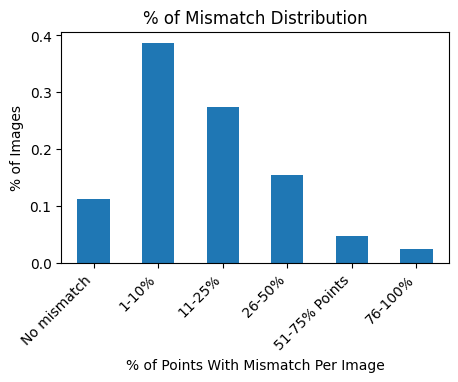

In [34]:
plt.figure(figsize=(5, 3))
pd.cut(
    REEF_SUPPORT_DF.points_mismatch_percent,
    bins=percent_bins,
    labels=percent_labels
    )\
    .value_counts(normalize=True, sort=False)\
    .plot(kind="bar")
plt.title("% of Mismatch Distribution")
plt.xlabel("% of Points With Mismatch Per Image")
plt.ylabel("% of Images")
plt.xticks(rotation=45, ha='right')
plt.show()

### Image Level Status By Region

In [35]:
REEF_SUPPORT_DF\
    .groupby(['region', 'class_label_comparison'])\
    .agg(samples_count=('quadratid', 'count'))\
    .reset_index()

,region,class_label_comparison,samples_count
0,ATL,Match,128
1,ATL,Mismatch,577
2,PAC_AUS,Match,118
3,PAC_AUS,Mismatch,690
4,PAC_IDN_PHL,Match,35
5,PAC_IDN_PHL,Mismatch,431
6,PAC_USA,Match,22
7,PAC_USA,Mismatch,706


### Top Species With Mismatch

In [36]:
RS_POINT_LABELS_DF\
    .query("class_label_comparison == 'Mismatch'")\
    .groupby(['reef_support_class_name', 'seaview_class_name', 'label_name'])\
    .agg(
        points_count=('quadratid', 'count'),
        samples_count=('quadratid', 'nunique'),
        )\
    .reset_index()\
    .sort_values(by=['samples_count', 'points_count'], ascending=False)

,reef_support_class_name,seaview_class_name,label_name,points_count,samples_count
19,Hard Coral,Others,Epilithic Algal Matrix,15487,1301
16,Hard Coral,Others,EAM: Dead Hard Coral,850,268
56,Hard Coral,Others,Sponge,527,229
89,Others,Hard Coral,Acroporidae plate/encrusting,670,198
110,Others,Hard Coral,MASE: Small or Invis Polyps,582,190
...,...,...,...,...,...
204,Soft Coral,Others,Loose Substrate: Rubble,1,1
209,Soft Coral,Others,Massive or encrusting sponges,1,1
212,Soft Coral,Others,Niphates digitalis,1,1
223,Soft Coral,Others,Vase sponge,1,1


In [37]:
RS_POINT_LABELS_DF\
    .query("class_label_comparison == 'Mismatch'")\
    .groupby(['reef_support_class_name', 'seaview_class_name', 'label_name'])\
    .agg(
        points_count=('quadratid', 'count'),
        samples_count=('quadratid', 'nunique'),
        )\
    .reset_index()\
    .sort_values(by=['samples_count', 'points_count'], ascending=False)\
    .label_name.nunique()

150

### Top Species With Mismatch (Region Wise)

In [38]:
RS_POINT_LABELS_DF\
    .query("class_label_comparison == 'Mismatch'")\
    .groupby(['region', 'reef_support_class_name', 'seaview_class_name', 'label_name'])\
    .agg(
        points_count=('quadratid', 'count'),
        samples_count=('quadratid', 'nunique'),
        )\
    .reset_index()\
    .sort_values(by=['region', 'samples_count', 'points_count'], ascending=False)\
    .groupby(['region'])\
    .head(3)

,region,reef_support_class_name,seaview_class_name,label_name,points_count,samples_count
219,PAC_USA,Hard Coral,Others,Epilithic Algal Matrix,13718,696
226,PAC_USA,Hard Coral,Others,Sponge,527,229
239,PAC_USA,Others,Hard Coral,Porites lobata/lutea,162,96
144,PAC_IDN_PHL,Hard Coral,Others,EAM: Dead Hard Coral,850,268
145,PAC_IDN_PHL,Hard Coral,Others,Epilithic Algal Matrix,767,246
184,PAC_IDN_PHL,Others,Hard Coral,MASE: Small or Invis Polyps,582,190
98,PAC_AUS,Hard Coral,Others,Epilithic Algal Matrix,946,319
113,PAC_AUS,Others,Hard Coral,Acroporidae plate/encrusting,670,198
119,PAC_AUS,Others,Hard Coral,Pocilloporidae,317,189
55,ATL,Others,Soft Coral,Soft Coral plumes,255,121


In [39]:
RS_POINT_LABELS_DF\
    .query("class_label_comparison == 'Mismatch'")\
    .groupby(['region', 'reef_support_class_name', 'seaview_class_name', 'label_name'])\
    .agg(
        points_count=('quadratid', 'count'),
        samples_count=('quadratid', 'nunique'),
        )\
    .reset_index()\
    .sort_values(by=['region', 'samples_count', 'points_count'], ascending=False)\
    .query("label_name == 'Hydroids feathery types'")

,region,reef_support_class_name,seaview_class_name,label_name,points_count,samples_count
210,PAC_IDN_PHL,Soft Coral,Others,Hydroids feathery types,126,21
152,PAC_IDN_PHL,Hard Coral,Others,Hydroids feathery types,2,2


## Visualize Mismatch Samples

### Select Samples

In [40]:
REEF_SUPPORT_DF\
    .query("points_mismatch_percent > 90")\
    .query("points_mismatch_percent < 110")\
    .query("points_selection_method == 'random'")

,quadratid,region,folder,mask_patches,mask_stitched,height,width,mask_height,mask_width,other_pixels,...,points_selection_method,point_labels_count,comparison_status,class_label_comparison,points_mismatch_count,hard_coral_mismatch_count,soft_coral_mismatch_count,points_mismatch_percent,hard_coral_mismatch_percent,soft_coral_mismatch_percent
2045,44005154201,PAC_USA,SEAVIEW_PAC_USA,1,1,1138,1138,1138,1138,0,...,random,50,SUCCESS,Mismatch,46,46,0,92.0,92.0,0.0
2054,44005155501,PAC_USA,SEAVIEW_PAC_USA,1,1,1709,1709,1709,1709,0,...,random,50,SUCCESS,Mismatch,47,47,0,94.0,94.0,0.0
2055,44005155901,PAC_USA,SEAVIEW_PAC_USA,1,1,1410,1410,1410,1410,0,...,random,50,SUCCESS,Mismatch,46,46,0,92.0,92.0,0.0
2056,44005155701,PAC_USA,SEAVIEW_PAC_USA,1,1,1326,1326,1326,1326,0,...,random,50,SUCCESS,Mismatch,49,49,0,98.0,98.0,0.0
2059,44005156001,PAC_USA,SEAVIEW_PAC_USA,1,1,1356,1356,1356,1356,71862,...,random,50,SUCCESS,Mismatch,49,49,0,98.0,98.0,0.0
2239,44036247201,PAC_USA,SEAVIEW_PAC_USA,1,1,1398,1398,1398,1398,125007,...,random,50,SUCCESS,Mismatch,47,47,0,94.0,94.0,0.0
2443,32018142301,PAC_IDN_PHL,SEAVIEW_IDN_PHL,1,1,1164,1164,1164,1164,204213,...,random,50,SUCCESS,Mismatch,48,48,0,96.0,96.0,0.0
2444,32018142401,PAC_IDN_PHL,SEAVIEW_IDN_PHL,5,1,1366,1366,1366,1366,601389,...,random,50,SUCCESS,Mismatch,49,45,0,98.0,90.0,0.0
2446,32018142501,PAC_IDN_PHL,SEAVIEW_IDN_PHL,1,1,1481,1481,1481,1481,339333,...,random,50,SUCCESS,Mismatch,50,49,0,100.0,98.0,0.0
2450,32018142901,PAC_IDN_PHL,SEAVIEW_IDN_PHL,1,1,1125,1125,1125,1125,8877,...,random,50,SUCCESS,Mismatch,49,49,0,98.0,98.0,0.0


### Visualize Mismatch

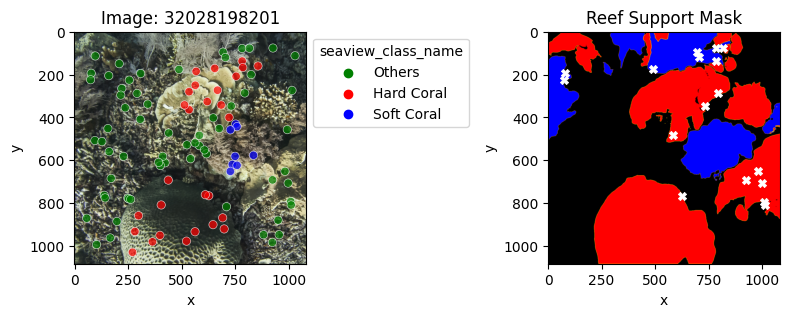

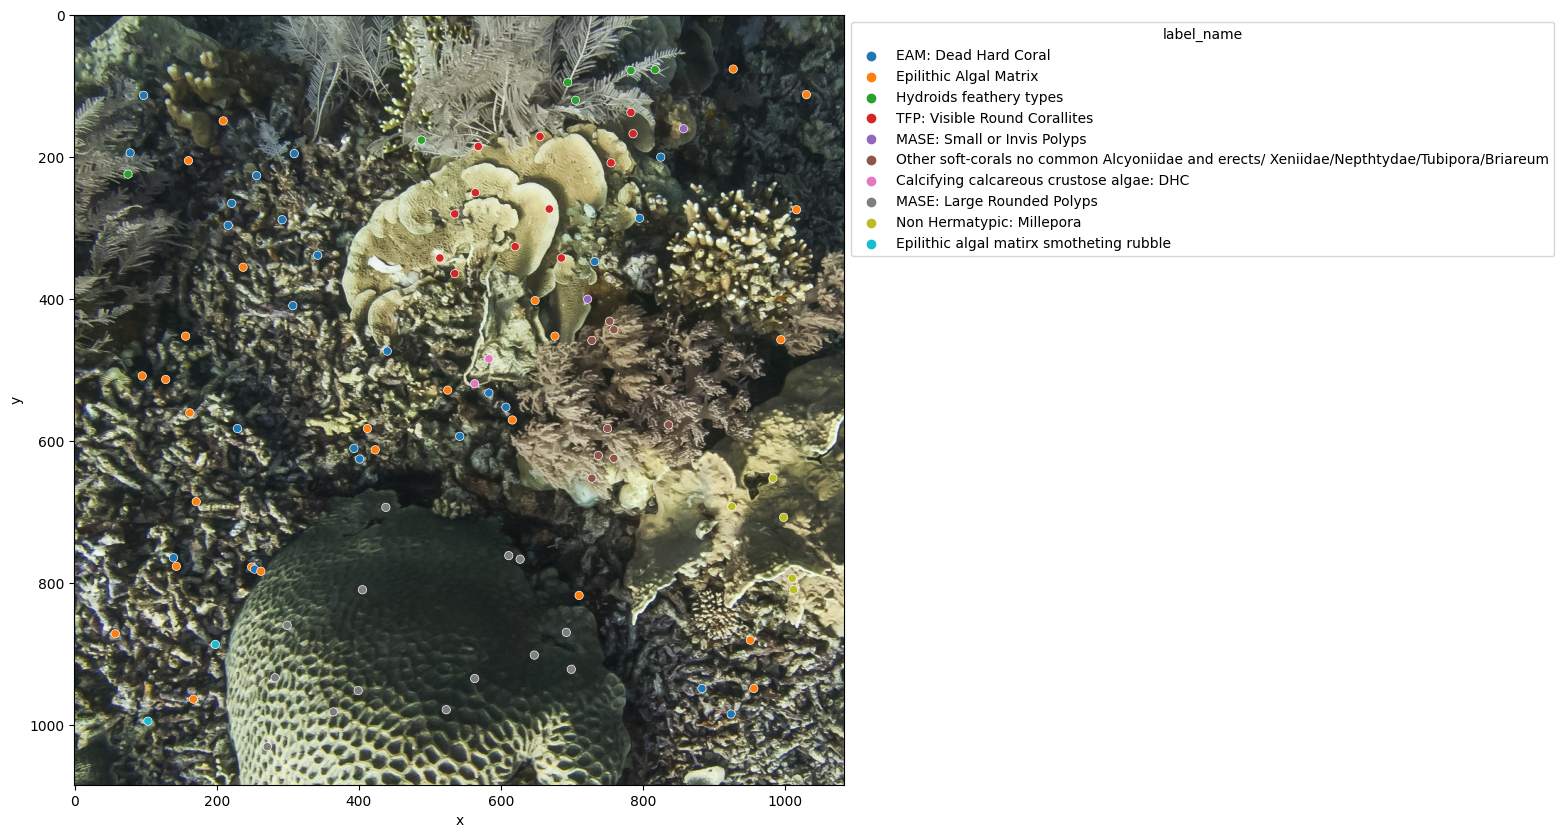

In [41]:
quadrat_ids = [10002015302, 44005156001, 25009011101, 12021029501, 32018143101, 10002015302, 32028198201, 32009271301]
quadrat_ids = [32028198201]

for quadrat_id in quadrat_ids:
    # read original image from seaview folders
    seaview_folder = REEF_SUPPORT_DF.query(f"quadratid == {quadrat_id}").region.item()
    image_path = os.path.join(SEAVIEW_PL_IMAGES_PATH, seaview_folder, f"{quadrat_id}.jpg")
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # get point label details
    point_labels_df = RS_POINT_LABELS_DF.query(f"quadratid == {quadrat_id}").copy()

    # read dense ground truth mask from reef_support folders
    reef_support_folder = REEF_SUPPORT_DF.query(f"quadratid == {quadrat_id}").folder.item()
    rs_mask_path = os.path.join(REEF_SUPPORT_DATA_PATH, reef_support_folder, 'masks_stitched', f"{quadrat_id}_mask.png")
    rs_mask = cv2.imread(rs_mask_path)
    rs_mask = cv2.cvtColor(rs_mask, cv2.COLOR_BGR2RGB)

    # plot original image and ground truth mask with class name labels
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
    # original image with seaview class labels
    ax[0].imshow(image)
    sns.scatterplot(
        data=point_labels_df,
        x='x', y='y', hue='seaview_class_name',
        palette=CLASS_PALETTE, alpha=0.7, ax=ax[0],
        )
    sns.move_legend(ax[0], 'upper left', bbox_to_anchor=(1, 1))
    ax[0].set_title(f"Image: {quadrat_id}")
    # reef_support mask
    ax[1].imshow(rs_mask)
    sns.scatterplot(
        data=point_labels_df.query("class_label_comparison == 'Mismatch'"),
        x='x', y='y', color='white', marker='X', legend=False, ax=ax[1],
        )
    ax[1].set_title("Reef Support Mask")
    plt.tight_layout()
    plt.show()

    # plot original image with species level labels from seaview
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    ax = sns.scatterplot(data=point_labels_df, x='x', y='y', hue='label_name')
    sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
    plt.show()